In [1]:
# 1. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import warnings
warnings.filterwarnings('ignore')

#Get all file paths and print
file_paths = glob.glob(os.path.join('/Users/spartan/Desktop/MLproject/har70plus', '*'))

In [2]:
# # 1. Imports
# import pandas as pd
# import numpy as np
# from scipy.fft import fft
# from collections import Counter
# import glob
# import os
# import random
# from sklearn.utils import resample
# import warnings
# warnings.filterwarnings('ignore')

# # 2. Shuffle and split subjects randomly
# file_paths = glob.glob(os.path.join('/Users/spartan/Desktop/MLproject/har70plus', '*'))

# random.seed(42)
# random.shuffle(file_paths)

# split_idx = int(0.8 * len(file_paths))
# train_file_paths = file_paths[:split_idx]
# test_file_paths = file_paths[split_idx:]

# print(f"Training subjects: {len(train_file_paths)}, Testing subjects: {len(test_file_paths)}")

# # 3. Fourier-only feature extraction function
# def extract_fft_features(window_df, sampling_rate=50):
#     features = {}
    
#     sensor_cols = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
    
#     window_df['back_mag'] = np.sqrt(window_df['back_x']**2 + window_df['back_y']**2 + window_df['back_z']**2)
#     window_df['thigh_mag'] = np.sqrt(window_df['thigh_x']**2 + window_df['thigh_y']**2 + window_df['thigh_z']**2)
    
#     for col in sensor_cols + ['back_mag', 'thigh_mag']:
#         arr = window_df[col].to_numpy()
#         fft_vals = np.abs(fft(arr))
#         n = len(arr)
        
#         freqs = np.fft.fftfreq(n, d=1/sampling_rate)
        
#         dom_idx = np.argmax(fft_vals[1:]) + 1
#         dom_freq = abs(freqs[dom_idx])
        
#         spectral_energy = np.sum(fft_vals**2)
        
#         features[f'{col}_dom_freq_hz'] = dom_freq
#         features[f'{col}_spectral_energy'] = spectral_energy
    
#     return features

# # 4. Process a subject file
# def process_subject_fft(file_path, window_size_seconds=1, sampling_rate=50):
#     df = pd.read_csv(file_path)
    
#     df['timestamp'] = pd.to_datetime(df['timestamp'])
#     df = df.sort_values('timestamp')
    
#     features_list = []
#     labels_list = []
    
#     start_idx = 0
#     total_samples = df.shape[0]
    
#     while start_idx < total_samples:
#         start_time = df.iloc[start_idx]['timestamp']
#         end_time = start_time + pd.Timedelta(seconds=window_size_seconds)
        
#         window_df = df[(df['timestamp'] >= start_time) & (df['timestamp'] < end_time)]
        
#         if len(window_df) < 10:
#             start_idx += 1
#             continue
        
#         features = extract_fft_features(window_df, sampling_rate)
#         majority_label = Counter(window_df['label']).most_common(1)[0][0]
        
#         features_list.append(features)
#         labels_list.append(majority_label)
        
#         start_idx = window_df.index[-1] + 1
        
#     return pd.DataFrame(features_list), labels_list

# # 5. Process Train and Test sets
# X_train_list, y_train_list = [], []
# X_test_list, y_test_list = [], []

# for file in train_file_paths:
#     features_df, labels = process_subject_fft(file)
#     X_train_list.append(features_df)
#     y_train_list.extend(labels)

# for file in test_file_paths:
#     features_df, labels = process_subject_fft(file)
#     X_test_list.append(features_df)
#     y_test_list.extend(labels)

# # Final Datasets
# X_train = pd.concat(X_train_list, axis=0).reset_index(drop=True)
# y_train = np.array(y_train_list)

# X_test = pd.concat(X_test_list, axis=0).reset_index(drop=True)
# y_test = np.array(y_test_list)

# print("Before Balancing - Train shape:", X_train.shape, " Test shape:", X_test.shape)

# # 6. Count windows per label
# print("\nTrain label distribution BEFORE balancing:")
# print(pd.Series(y_train).value_counts().sort_index())

# print("\nTest label distribution:")
# print(pd.Series(y_test).value_counts().sort_index())

# # 7. BALANCE the training dataset
# train_df = X_train.copy()
# train_df['label'] = y_train

# # Find maximum class size
# max_size = train_df['label'].value_counts().max()

# # Resample each class to max size
# balanced_list = []
# for label in train_df['label'].unique():
#     subset = train_df[train_df['label'] == label]
#     balanced_subset = resample(subset, replace=True, n_samples=max_size, random_state=42)
#     balanced_list.append(balanced_subset)

# balanced_train_df = pd.concat(balanced_list).reset_index(drop=True)

# # New Train Data
# X_train_balanced = balanced_train_df.drop('label', axis=1)
# y_train_balanced = balanced_train_df['label'].to_numpy()

# print("\nAfter Balancing - Train shape:", X_train_balanced.shape)

# # 8. Ready for modeling


In [3]:
# 1. Imports
import pandas as pd
import numpy as np
import os
import glob
import random
from scipy.fft import fft
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# 2. Shuffle and split subjects randomly
file_paths = glob.glob(os.path.join('/Users/spartan/Desktop/MLproject/har70plus', '*'))

random.seed(42)  # for reproducibility
random.shuffle(file_paths)

# 80% train, 20% test
split_idx = int(0.7 * len(file_paths))
train_file_paths = file_paths[:split_idx]
test_file_paths = file_paths[split_idx:]

print(f"Training subjects: {len(train_file_paths)}, Testing subjects: {len(test_file_paths)}")

# 3. Fourier-only feature extraction function
def extract_fft_features(window_df, sampling_rate=50):
    features = {}
    
    sensor_cols = ['back_x', 'back_z', 'thigh_x', 'thigh_z'] #, 'back_y','thigh_y'
    
    window_df['back_mag'] = np.sqrt(window_df['back_x']**2 + window_df['back_y']**2 + window_df['back_z']**2)
    window_df['thigh_mag'] = np.sqrt(window_df['thigh_x']**2 + window_df['thigh_y']**2 + window_df['thigh_z']**2)
    
    for col in sensor_cols + ['back_mag', 'thigh_mag']:
        arr = window_df[col].to_numpy()
        fft_vals = np.abs(fft(arr))
        n = len(arr)
        
        freqs = np.fft.fftfreq(n, d=1/sampling_rate)
        
        dom_idx = np.argmax(fft_vals[1:]) + 1
        dom_freq = abs(freqs[dom_idx])
        
        spectral_energy = np.sum(fft_vals**2)
        
        features[f'{col}_dom_freq_hz'] = dom_freq
        features[f'{col}_spectral_energy'] = spectral_energy
    
    return features

# 3. Updated Fourier + Statistical Feature Extraction
from scipy.stats import mode

# def extract_fft_stat_features(window_df, sampling_rate=50):
#     features = {}
    
#     sensor_cols = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
    
#     # Magnitude columns
#     window_df['back_mag'] = np.sqrt(window_df['back_x']**2 + window_df['back_y']**2 + window_df['back_z']**2)
#     window_df['thigh_mag'] = np.sqrt(window_df['thigh_x']**2 + window_df['thigh_y']**2 + window_df['thigh_z']**2)
    
#     for col in sensor_cols + ['back_mag', 'thigh_mag']:
#         arr = window_df[col].to_numpy()
#         fft_vals = np.abs(fft(arr))
#         n = len(arr)
        
#         freqs = np.fft.fftfreq(n, d=1/sampling_rate)
        
#         dom_idx = np.argmax(fft_vals[1:]) + 1
#         dom_freq = abs(freqs[dom_idx])
        
#         spectral_energy = np.sum(fft_vals**2)
        
#         # --- Add FFT Features ---
#         features[f'{col}_dom_freq_hz'] = dom_freq
#         features[f'{col}_spectral_energy'] = spectral_energy
        
#         # --- Add Statistical Features ---
#         features[f'{col}_mean'] = np.mean(arr)
#         features[f'{col}_median'] = np.median(arr)
#         features[f'{col}_std'] = np.std(arr)
#         features[f'{col}_mode'] = mode(arr, keepdims=False)[0]  # Using scipy's mode
        
#     return features


# 4. Process a subject file
def process_subject_fft(file_path, window_size_seconds=5, sampling_rate=50):
    df = pd.read_csv(file_path)
    
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')
    
    features_list = []
    labels_list = []
    
    start_idx = 0
    total_samples = df.shape[0]
    
    while start_idx < total_samples:
        start_time = df.iloc[start_idx]['timestamp']
        end_time = start_time + pd.Timedelta(seconds=window_size_seconds)
        
        window_df = df[(df['timestamp'] >= start_time) & (df['timestamp'] < end_time)]
        
        if len(window_df) < 10:
            start_idx += 1
            continue
        
        features = extract_fft_features(window_df, sampling_rate)
        # features = extract_fft_stat_features(window_df, sampling_rate)
        majority_label = Counter(window_df['label']).most_common(1)[0][0]
        
        features_list.append(features)
        labels_list.append(majority_label)
        
        start_idx = window_df.index[-1] + 1
        
    return pd.DataFrame(features_list), labels_list

# 5. Process all files
X_train_list, y_train_list = [], []
X_test_list, y_test_list = [], []

for file in train_file_paths:
    features_df, labels = process_subject_fft(file)
    X_train_list.append(features_df)
    y_train_list.extend(labels)

for file in test_file_paths:
    features_df, labels = process_subject_fft(file)
    X_test_list.append(features_df)
    y_test_list.extend(labels)

# 6. Final datasets
X_train = pd.concat(X_train_list, axis=0).reset_index(drop=True)
y_train = np.array(y_train_list)

X_test = pd.concat(X_test_list, axis=0).reset_index(drop=True)
y_test = np.array(y_test_list)

print("Final X_train shape:", X_train.shape)
print("Final X_test shape:", X_test.shape)


Training subjects: 12, Testing subjects: 6
Final X_train shape: (5973, 12)
Final X_test shape: (3162, 12)


In [4]:
# # 1. Imports
# import pandas as pd
# import numpy as np
# import os
# import glob
# import random
# from scipy.fft import fft
# from collections import Counter
# import warnings
# from sklearn.preprocessing import StandardScaler

# warnings.filterwarnings('ignore')

# # 2. Shuffle and split subjects randomly
# file_paths = glob.glob(os.path.join('/Users/spartan/Desktop/MLproject/har70plus', '*'))

# random.seed(42)
# random.shuffle(file_paths)

# split_idx = int(0.7 * len(file_paths))
# train_file_paths = file_paths[:split_idx]
# test_file_paths = file_paths[split_idx:]

# print(f"Training subjects: {len(train_file_paths)}, Testing subjects: {len(test_file_paths)}")

# # 3. FFT-only feature extraction function
# def extract_fft_features(window_df, sampling_rate=50):
#     features = {}
#     sensor_cols = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
    
#     window_df['back_mag'] = np.sqrt(window_df['back_x']**2 + window_df['back_y']**2 + window_df['back_z']**2)
#     window_df['thigh_mag'] = np.sqrt(window_df['thigh_x']**2 + window_df['thigh_y']**2 + window_df['thigh_z']**2)
    
#     for col in sensor_cols + ['back_mag', 'thigh_mag']:
#         arr = window_df[col].to_numpy()
#         fft_vals = np.abs(fft(arr))
#         n = len(arr)
#         freqs = np.fft.fftfreq(n, d=1/sampling_rate)
#         dom_idx = np.argmax(fft_vals[1:]) + 1
#         dom_freq = abs(freqs[dom_idx])
#         spectral_energy = np.sum(fft_vals**2)
        
#         features[f'{col}_dom_freq_hz'] = dom_freq
#         features[f'{col}_spectral_energy'] = spectral_energy
    
#     return features

# # 4. Process a subject file
# def process_subject_fft(file_path, window_size_seconds=5, sampling_rate=50):
#     df = pd.read_csv(file_path)
#     df['timestamp'] = pd.to_datetime(df['timestamp'])
#     df = df.sort_values('timestamp')
    
#     features_list = []
#     labels_list = []
    
#     start_idx = 0
#     total_samples = df.shape[0]
    
#     while start_idx < total_samples:
#         start_time = df.iloc[start_idx]['timestamp']
#         end_time = start_time + pd.Timedelta(seconds=window_size_seconds)
#         window_df = df[(df['timestamp'] >= start_time) & (df['timestamp'] < end_time)]
        
#         if len(window_df) < 10:
#             start_idx += 1
#             continue
        
#         features = extract_fft_features(window_df, sampling_rate)
#         majority_label = Counter(window_df['label']).most_common(1)[0][0]
        
#         features_list.append(features)
#         labels_list.append(majority_label)
        
#         start_idx = window_df.index[-1] + 1
        
#     return pd.DataFrame(features_list), labels_list

# # 5. Process all files
# X_train_list, y_train_list = [], []
# X_test_list, y_test_list = [], []

# for file in train_file_paths:
#     features_df, labels = process_subject_fft(file)
#     X_train_list.append(features_df)
#     y_train_list.extend(labels)

# for file in test_file_paths:
#     features_df, labels = process_subject_fft(file)
#     X_test_list.append(features_df)
#     y_test_list.extend(labels)

# # 6. Final datasets
# X_train = pd.concat(X_train_list, axis=0).reset_index(drop=True)
# y_train = np.array(y_train_list)
# X_test = pd.concat(X_test_list, axis=0).reset_index(drop=True)
# y_test = np.array(y_test_list)

# print("Before cleaning:")
# print("X_train shape:", X_train.shape)

# # ====================================
# # 7. Remove Outliers (IQR Method)
# # ====================================
# Q1 = X_train.quantile(0.25)
# Q3 = X_train.quantile(0.75)
# IQR = Q3 - Q1

# is_outlier = ((X_train < (Q1 - 1.5 * IQR)) | (X_train > (Q3 + 1.5 * IQR))).any(axis=1)

# # Filter
# X_train = X_train[~is_outlier].reset_index(drop=True)
# y_train = y_train[~is_outlier.to_numpy()]

# print("After removing outliers:")
# print("X_train shape:", X_train.shape)

# # ====================================
# # 8. Feature Scaling (Standardization)
# # ====================================
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Convert back to DataFrame
# X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
# X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# print("Data standardized successfully.")



Training: Random Forest
Accuracy: 0.9048
Classification Report:
              precision    recall  f1-score   support

           1       0.91      0.98      0.94      1514
           3       1.00      0.03      0.06        62
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         9
           6       0.93      0.87      0.90       668
           7       1.00      0.84      0.91       681
           8       0.68      0.99      0.80       223

    accuracy                           0.90      3162
   macro avg       0.64      0.53      0.52      3162
weighted avg       0.91      0.90      0.90      3162



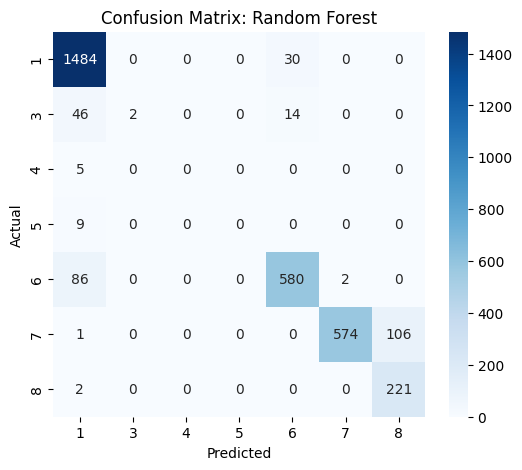


Training: Decision Tree
Accuracy: 0.8868
Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.97      0.94      1514
           3       0.17      0.08      0.11        62
           4       0.10      0.20      0.13         5
           5       0.00      0.00      0.00         9
           6       0.92      0.80      0.86       668
           7       0.99      0.84      0.91       681
           8       0.75      0.99      0.85       223

    accuracy                           0.89      3162
   macro avg       0.55      0.55      0.54      3162
weighted avg       0.90      0.89      0.89      3162



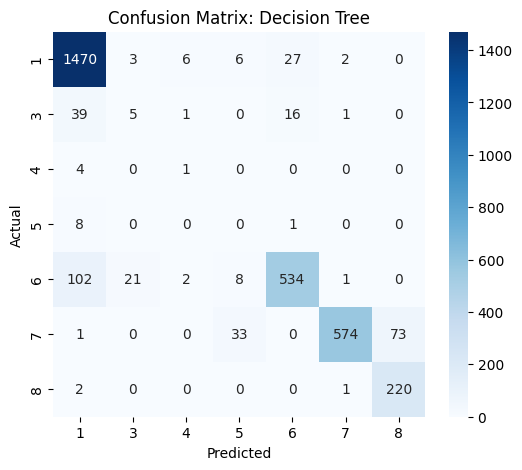


Training: Logistic Regression
Accuracy: 0.8871
Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.98      0.93      1514
           3       0.00      0.00      0.00        62
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         9
           6       0.92      0.79      0.85       668
           7       1.00      0.84      0.91       681
           8       0.67      1.00      0.80       223

    accuracy                           0.89      3162
   macro avg       0.50      0.52      0.50      3162
weighted avg       0.88      0.89      0.88      3162



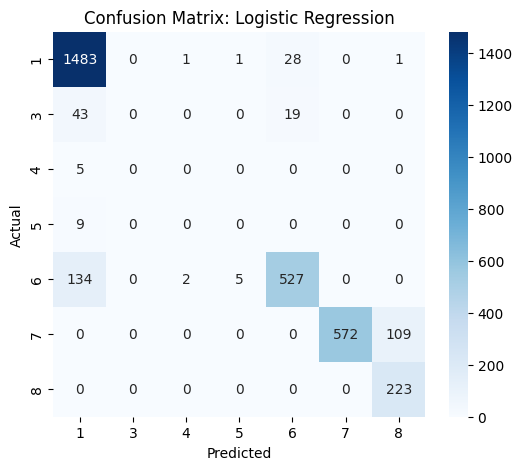


Training: SVM (Linear Kernel)
Accuracy: 0.7340
Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.73      0.83      1514
           3       0.09      0.45      0.14        62
           4       0.01      0.20      0.01         5
           5       0.01      0.22      0.02         9
           6       0.95      0.59      0.73       668
           7       1.00      0.84      0.91       681
           8       0.67      0.99      0.80       223

    accuracy                           0.73      3162
   macro avg       0.53      0.57      0.49      3162
weighted avg       0.92      0.73      0.81      3162



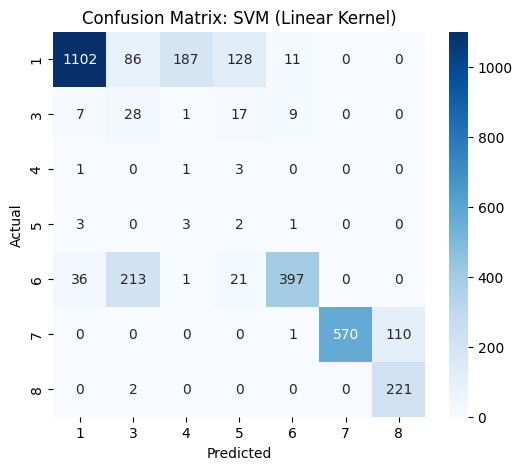


Training: SVM (RBF Kernel)
Accuracy: 0.8295
Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.88      0.92      1514
           3       0.08      0.32      0.13        62
           4       0.00      0.00      0.00         5
           5       0.06      0.67      0.10         9
           6       0.92      0.71      0.80       668
           7       1.00      0.83      0.91       681
           8       0.67      0.99      0.80       223

    accuracy                           0.83      3162
   macro avg       0.53      0.63      0.52      3162
weighted avg       0.92      0.83      0.87      3162



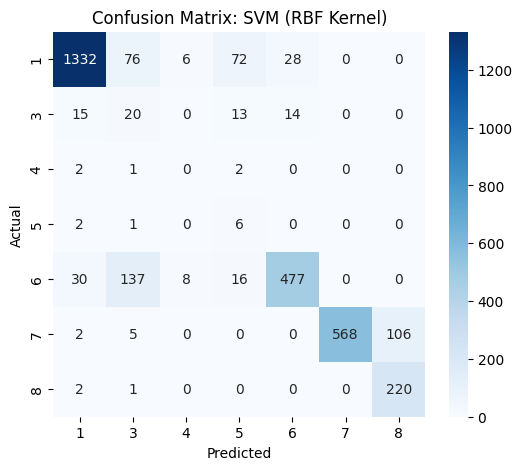


Training: K-Nearest Neighbors (KNN)
Accuracy: 0.8684
Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.98      0.92      1514
           3       0.00      0.00      0.00        62
           4       0.14      0.20      0.17         5
           5       0.00      0.00      0.00         9
           6       0.92      0.71      0.80       668
           7       0.98      0.84      0.90       681
           8       0.66      0.95      0.78       223

    accuracy                           0.87      3162
   macro avg       0.51      0.53      0.51      3162
weighted avg       0.87      0.87      0.86      3162



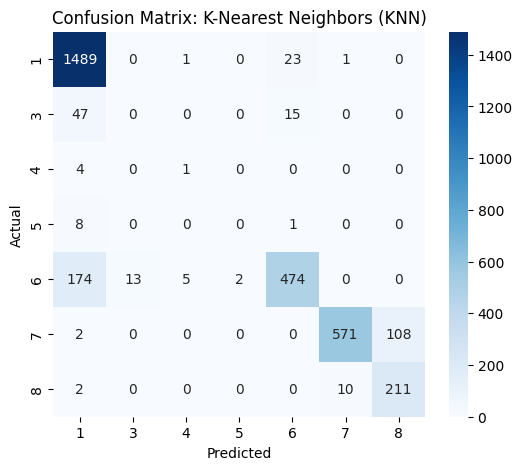


Training: Gradient Boosting
Accuracy: 0.8956
Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.96      0.94      1514
           3       0.33      0.02      0.03        62
           4       0.25      0.40      0.31         5
           5       0.00      0.00      0.00         9
           6       0.92      0.88      0.90       668
           7       1.00      0.84      0.91       681
           8       0.67      0.98      0.80       223

    accuracy                           0.90      3162
   macro avg       0.58      0.58      0.56      3162
weighted avg       0.90      0.90      0.89      3162



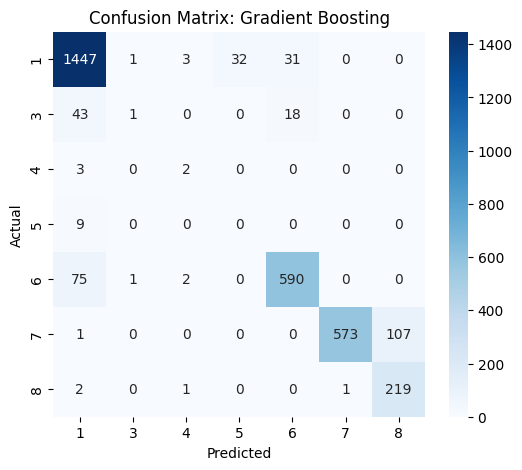


Training: XGB
Accuracy: 0.8956
Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.96      0.94      1514
           3       0.33      0.02      0.03        62
           4       0.25      0.40      0.31         5
           5       0.00      0.00      0.00         9
           6       0.92      0.88      0.90       668
           7       1.00      0.84      0.91       681
           8       0.67      0.98      0.80       223

    accuracy                           0.90      3162
   macro avg       0.58      0.58      0.56      3162
weighted avg       0.90      0.90      0.89      3162



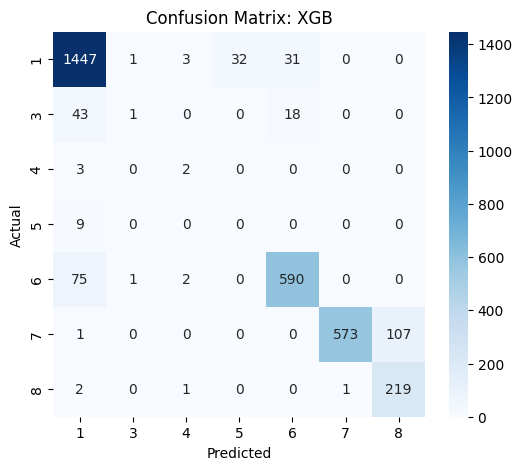


Training: AdaBoost
Accuracy: 0.8555
Classification Report:
              precision    recall  f1-score   support

           1       0.91      0.96      0.93      1514
           3       0.00      0.00      0.00        62
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         9
           6       0.87      0.85      0.86       668
           7       0.75      1.00      0.86       681
           8       0.00      0.00      0.00       223

    accuracy                           0.86      3162
   macro avg       0.36      0.40      0.38      3162
weighted avg       0.78      0.86      0.81      3162



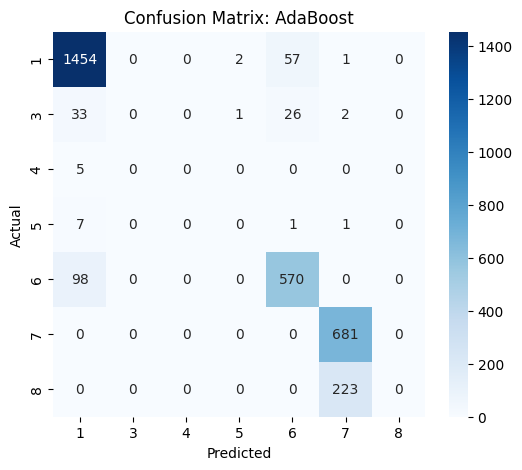


=== Model Performance Summary ===
Random Forest: 0.9048
Decision Tree: 0.8868
Logistic Regression: 0.8871
SVM (Linear Kernel): 0.7340
SVM (RBF Kernel): 0.8295
K-Nearest Neighbors (KNN): 0.8684
Gradient Boosting: 0.8956
XGB: 0.8956
AdaBoost: 0.8555


In [5]:
# 1. Imports
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Define all models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "SVM (Linear Kernel)": SVC(kernel='linear', random_state=42, class_weight='balanced'),
    "SVM (RBF Kernel)": SVC(kernel='rbf', random_state=42, class_weight='balanced'),
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGB": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
}

# 3. Train and Evaluate
results = {}

for name, model in models.items():
    print(f"\nTraining: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Optional: Confusion matrix plot for each model
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# 4. Summary of Accuracies
print("\n=== Model Performance Summary ===")
for model_name, acc in results.items():
    print(f"{model_name}: {acc:.4f}")


Computing ROC for: Random Forest
Computing ROC for: Decision Tree
Computing ROC for: Logistic Regression
Computing ROC for: SVM (Linear Kernel)
Computing ROC for: SVM (RBF Kernel)
Computing ROC for: K-Nearest Neighbors (KNN)
Computing ROC for: Gradient Boosting
Computing ROC for: XGB
Computing ROC for: AdaBoost


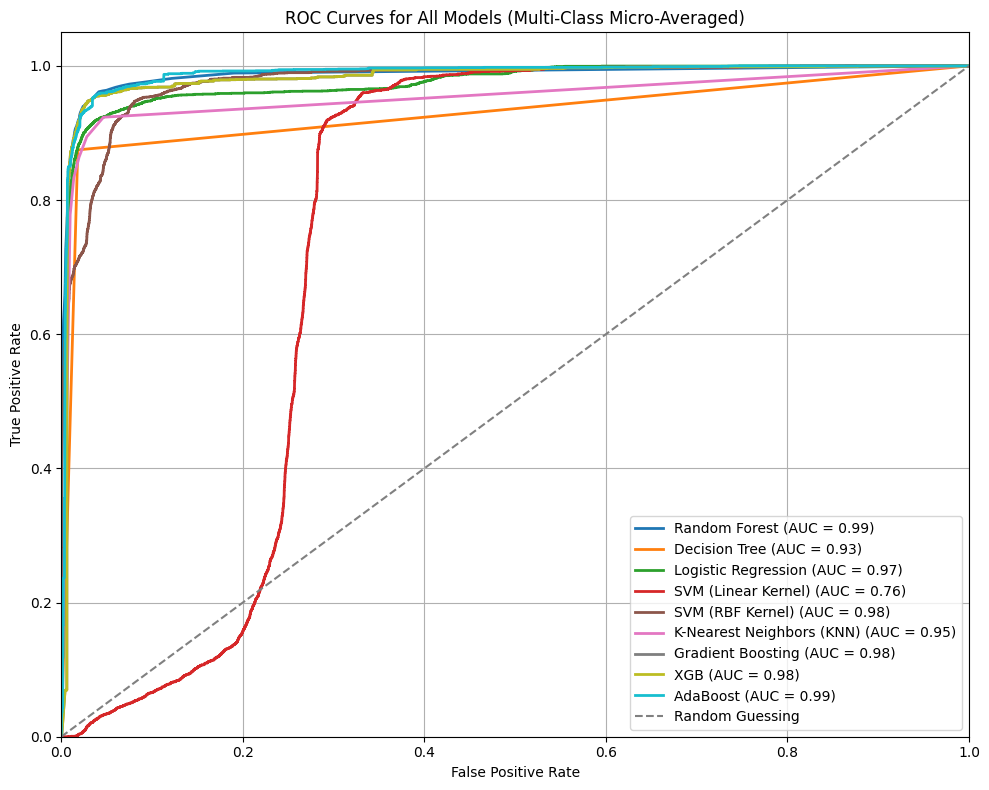

In [6]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Binarize the labels for multi-class ROC
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Plot setup
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap("tab10", len(models))

# Loop through each model and compute ROC
for i, (name, model) in enumerate(models.items()):
    print(f"Computing ROC for: {name}")

    # Some models need probability or decision function
    try:
        ovr = OneVsRestClassifier(model)
        ovr.fit(X_train, label_binarize(y_train, classes=classes))
        if hasattr(ovr, "predict_proba"):
            y_score = ovr.predict_proba(X_test)
        else:
            y_score = ovr.decision_function(X_test)

        # Compute micro-average ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})", color=colors(i))
    except Exception as e:
        print(f"Skipping {name} (no ROC available): {e}")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models (Multi-Class Micro-Averaged)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
# plt.savefig("confusion_matrix_rf_7_roc.png")
plt.show()


In [7]:
# # Random Forest Model
# rf_model = RandomForestClassifier(
#     n_estimators=100,
#     random_state=42,
#     n_jobs=-1,
#     class_weight='balanced'
# )

# # Train the model
# rf_model.fit(X_train, y_train)

# # Predict
# y_pred = rf_model.predict(X_test)

# # Evaluation
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# # Confusion Matrix
# plt.figure(figsize=(8,6))
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix (Manual Subject Split)')
# plt.show()

# # labels_dic = {
# #     1: 'walking', 3: "shiuffling", 4: "stairs (asc)",
# #     5: "stairs (desc)", 6: "standing", 7: "sitting", 8: "lying"
# # }

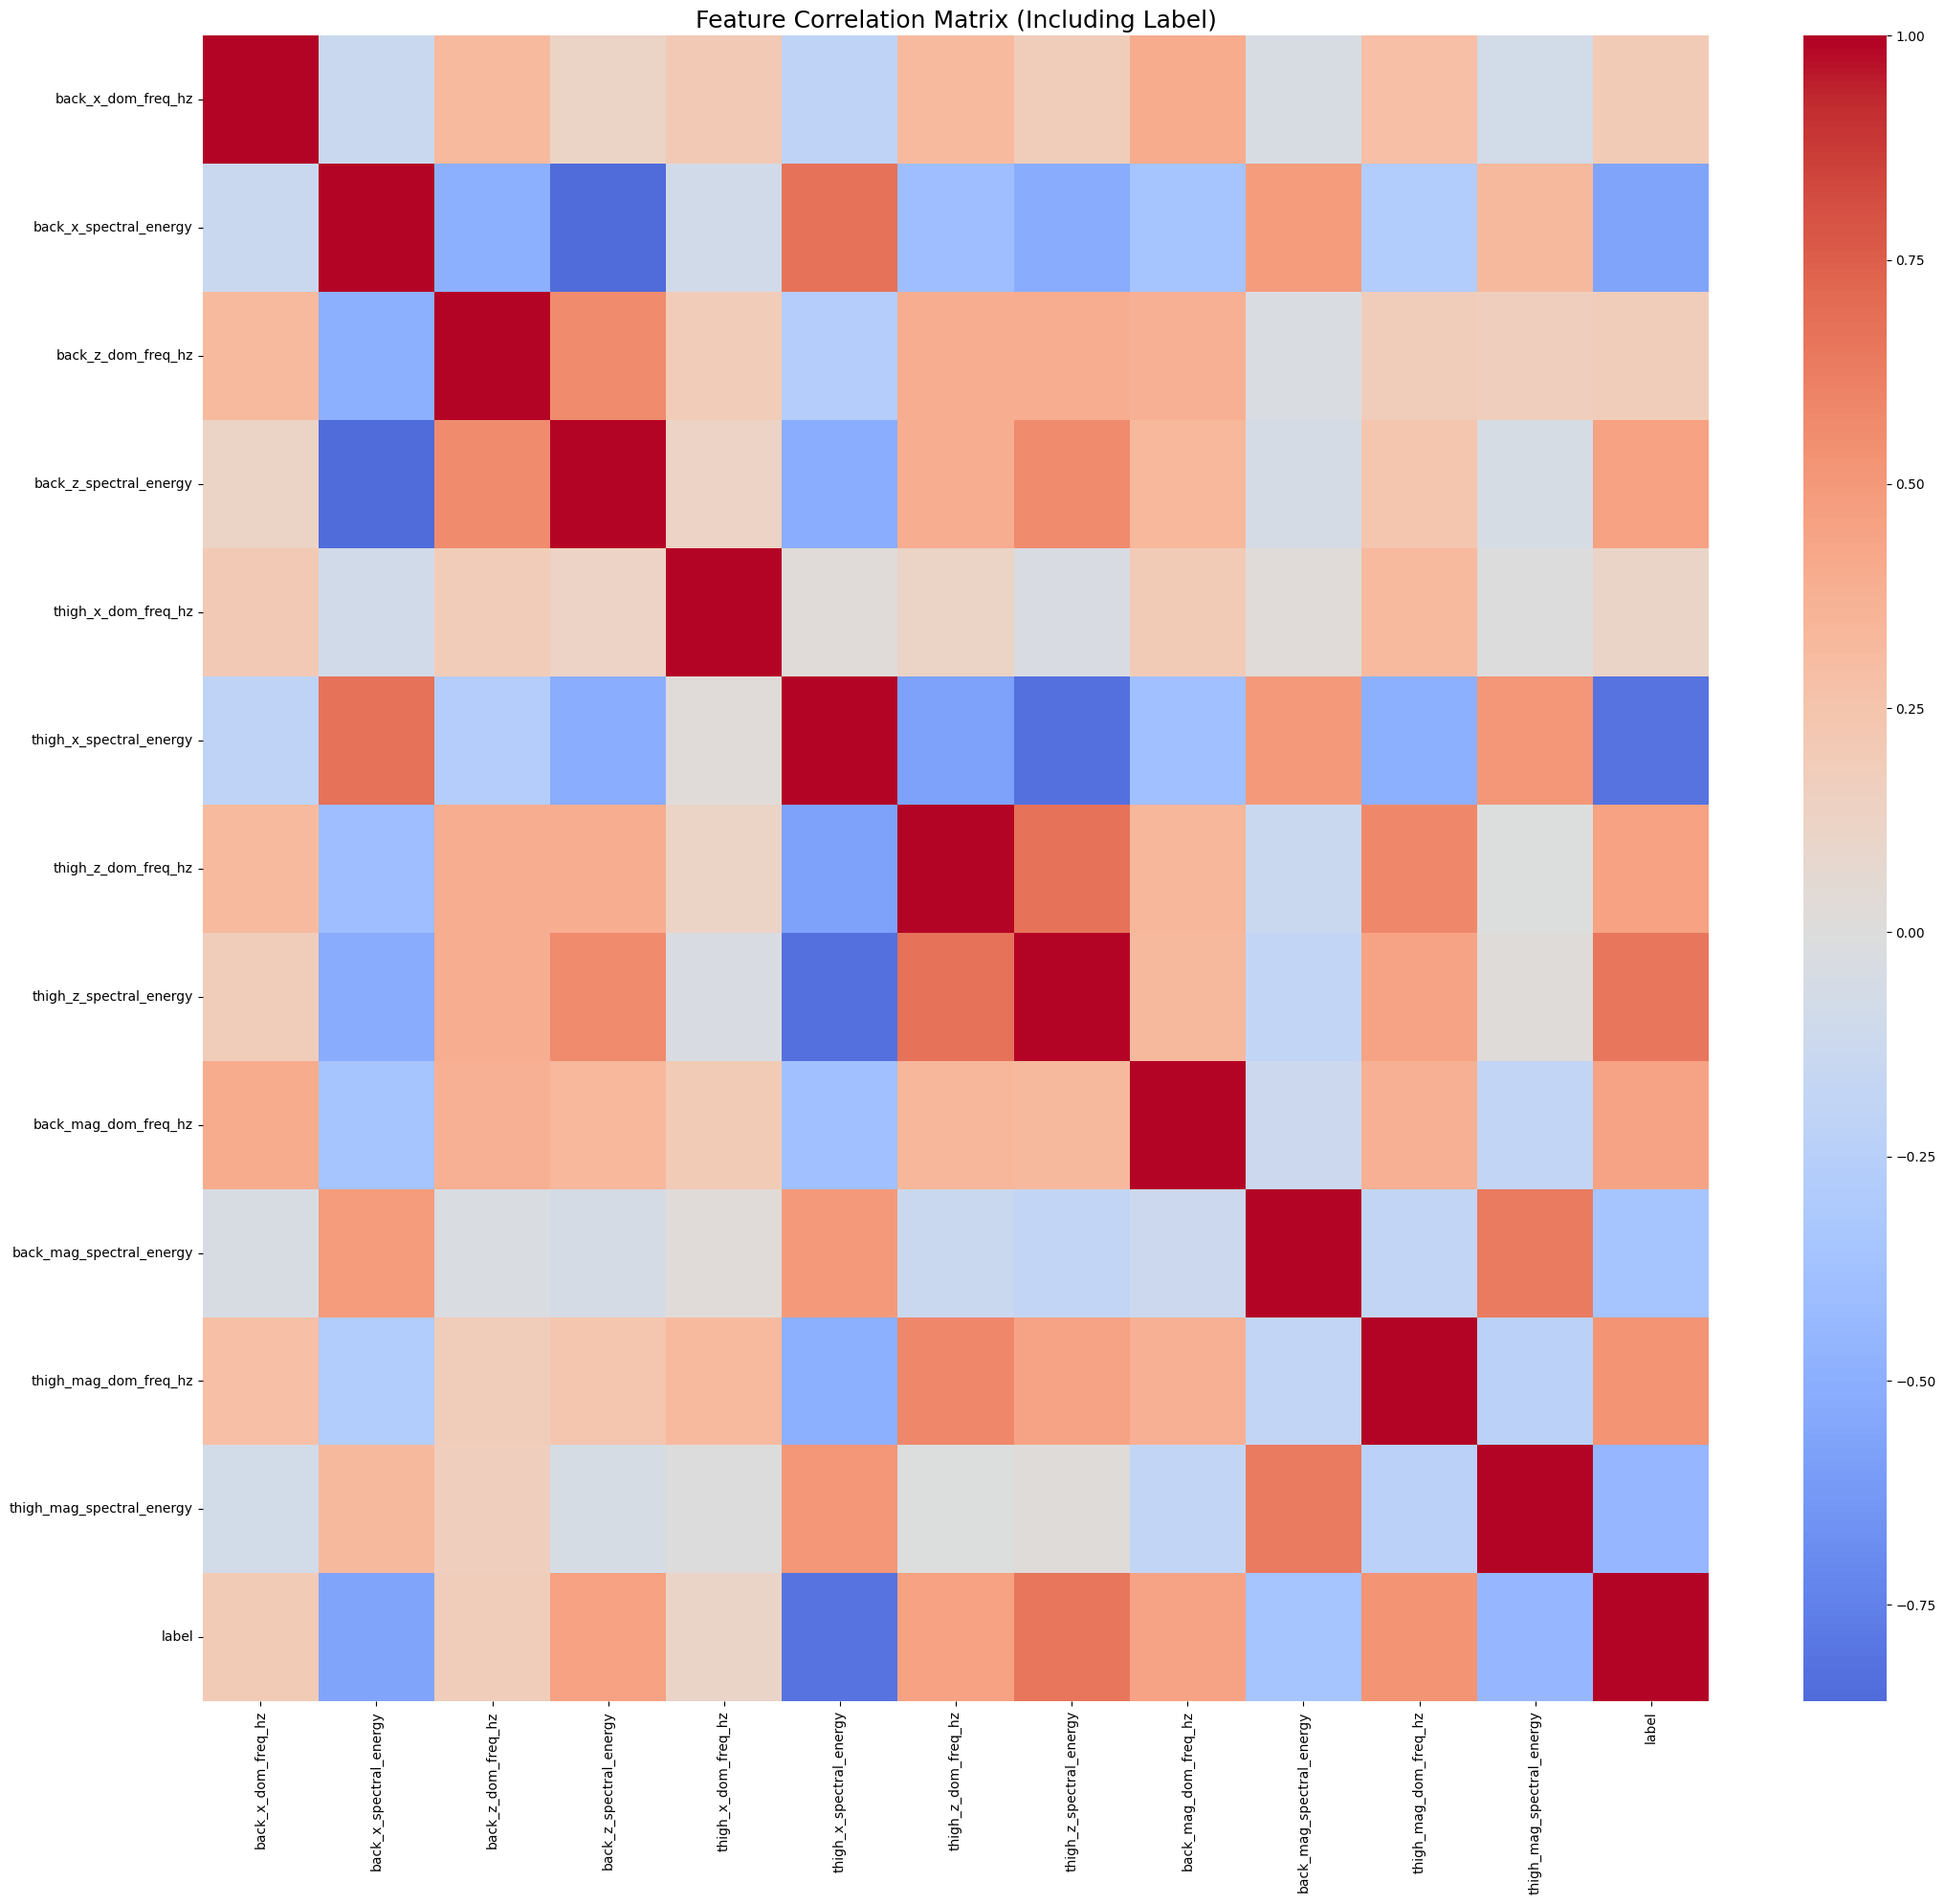


Top features correlated with Label:
label                        1.000000
thigh_z_spectral_energy      0.658785
thigh_mag_dom_freq_hz        0.525375
back_z_spectral_energy       0.462195
thigh_z_dom_freq_hz          0.458828
back_mag_dom_freq_hz         0.445398
back_x_dom_freq_hz           0.194829
back_z_dom_freq_hz           0.179973
thigh_x_dom_freq_hz          0.112855
back_mag_spectral_energy    -0.356048
thigh_mag_spectral_energy   -0.446513
back_x_spectral_energy      -0.566426
thigh_x_spectral_energy     -0.814122
Name: label, dtype: float64


In [8]:
# 1. Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 2. Assume X_train and y_train are ready

# Concatenate features and label
X_train_with_label = X_train.copy()
X_train_with_label['label'] = y_train

# 3. Calculate the correlation matrix
corr_matrix = X_train_with_label.corr()

# 4. Plot the heatmap
plt.figure(figsize=(22, 20))  # Increase size if many features
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix (Including Label)', fontsize=18)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.show()

# 5. Optional: Print top correlations with label
print("\nTop features correlated with Label:")
print(corr_matrix['label'].sort_values(ascending=False))


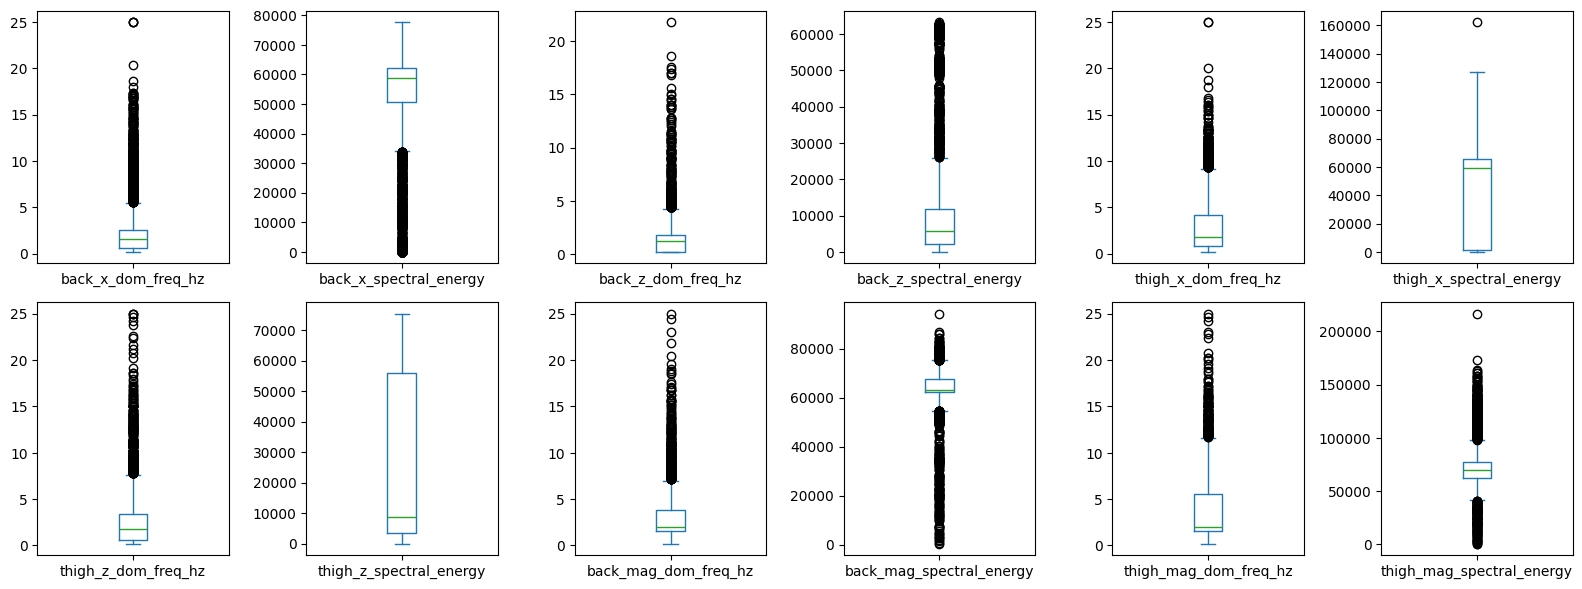

In [9]:
import matplotlib.pyplot as plt

X_train.plot(kind='box', figsize=(16, 6), subplots=True, layout=(2, int(X_train.shape[1]/2)))
plt.tight_layout()
plt.show()


#### NOTE:
The bar chart above shows the top 10 most important features. Several visible potential outliers were identified in the data. However, after removing them, the model's performance deteriorated significantly, indicating a risk of introducing bias. Therefore, I decided to retain these data points in the final model to preserve its generalization capability.